In [2]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import trange
from mpl_toolkits.axes_grid1 import AxesGrid
from utils import grabFileSeries, get_simulation_time, change_in_box
from utils import draw_xy_box, parse_input_file, div2D, dFdx, dFdy, rolling_average

print(yt.__version__)
os.system("python --version")
yt.set_log_level(50)        
"""
Possible values of set_log_level by increasing level:
        0 or "notset"
        1 or "all"
        10 or "debug"
        20 or "info"
        30 or "warning"
        40 or "error"
        50 or "critical"
"""

## Checking derived or innate field lists
# ds = ts[0]
# ds.derived_field_list
# print(ds.field_list)
# ad = ds.all_data()
# test = np.array(ad[('athena_pp', 'vel1')])
## Defining field variables so quickly changing them is easier
keoverme, keoverte = ('gas', 'KEoverME'), ('gas', 'KEoverTE')
current_eta_z = ('gas', 'current_eta_z')
div_MFT = ("gas", "magnetic_flux_transport_divergence")
ByoverBx = ("gas", "ByoverBx")
curlBz = ("gas", "curlBz")

Bcc1, Bcc2, Bcc3 = ('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3')
cell_volume = ('athena_pp', 'cell_volume')
dx, dy, dz = ('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz')
Etot = ('athena_pp', 'Etot')
path_element_x, path_element_y, path_element_z = ('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z')
press, rho = ('athena_pp', 'press'), ('athena_pp', 'rho')
vel1, vel2, vel3 = ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')
volume, x, y, z = ('athena_pp', 'volume'), ('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z')
alfven_speed, angular_momentum_magnitude = ('gas', 'alfven_speed'), ('gas', 'angular_momentum_magnitude')
angular_momentum_x, angular_momentum_y, angular_momentum_z = ('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z')
averaged_density, baroclinic_vorticity_magnitude = ('gas', 'averaged_density'), ('gas', 'baroclinic_vorticity_magnitude')
baroclinic_vorticity_x, baroclinic_vorticity_y, baroclinic_vorticity_z = ('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z')
cell_mass, cell_volume = ('gas', 'cell_mass'), ('gas', 'cell_volume')
courant_time_step, density = ('gas', 'courant_time_step'), ('gas', 'density')
density_gradient_magnitude, density_gradient_x, density_gradient_y, density_gradient_z = ('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z')
dx_gas, dy_gas, dynamical_time, dz_gas = ('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz')
jeans_mass, kT, kinetic_energy_density, lorentz_factor = ('gas', 'jeans_mass'), ('gas', 'kT'), ('gas', 'kinetic_energy_density'), ('gas', 'lorentz_factor')
mach_alfven, mach_number = ('gas', 'mach_alfven'), ('gas', 'mach_number')
magnetic_energy_density, magnetic_field_los, magnetic_field_magnitude = ('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude')
magnetic_field_strength, magnetic_field_x, magnetic_field_y, magnetic_field_z = ('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z')
magnetic_pressure, mass, mean_molecular_weight = ('gas', 'magnetic_pressure'), ('gas', 'mass'), ('gas', 'mean_molecular_weight')
momentum_density_x, momentum_density_y, momentum_density_z = ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z')
momentum_x, momentum_y, momentum_z = ('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z')
number_density, plasma_beta = ('gas', 'number_density'), ('gas', 'plasma_beta')
pressure, pressure_gradient_magnitude, pressure_gradient_x, pressure_gradient_y, pressure_gradient_z = ('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z')
relative_magnetic_field_x, relative_magnetic_field_y, relative_magnetic_field_z = ('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z')
relative_velocity_x, relative_velocity_y, relative_velocity_z = ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z')
shear, shear_criterion, shear_mach, sound_speed = ('gas', 'shear'), ('gas', 'shear_criterion'), ('gas', 'shear_mach'), ('gas', 'sound_speed')
specific_angular_momentum_magnitude, specific_angular_momentum_x, specific_angular_momentum_y, specific_angular_momentum_z = ('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z')
specific_thermal_energy, temperature, velocity_los = ('gas', 'specific_thermal_energy'), ('gas', 'temperature'), ('gas', 'velocity_los')
velocity_magnitude, velocity_x, velocity_y, velocity_z = ('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')
volume, vorticity_magnitude, vorticity_squared = ('gas', 'volume'), ('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared')
vorticity_x, vorticity_y, vorticity_z = ('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z')
x_gas, y_gas, z_gas = ('gas', 'x'), ('gas', 'y'), ('gas', 'z')

## Defining Dictionary for easy access
# scratchPath = "/mnt/gs21/scratch/freem386/"
directoryDict = {'rh1': 'recon_harris1/', 'rw1': 'recon_wire1/', 'rh2': 'recon_harris2/',
                 'rh3': 'recon_harris3/', 'rg1': 'recon_GEM1/', 'rb1': 'recon_bhat1/', 
                 'rb2': 'recon_bhat2/', 'rb3': 'recon_bhat3/',
                 'rf1': 'recon_freem1/', 'rf2': 'recon_freem2/', 'rf3': 'recon_freem3/',
                 'rf4': 'recon_freem4/', 'rf5': 'recon_freem5/', 'rf6': 'recon_freem6/',
                 'rf7': 'recon_freem7/', 'rf8': 'recon_freem8/',
                 'np0': 'non_periodic_test/', 'np2': 'non_periodic_test2/',
                 'rs1': 'recon_fast1/', 'rs2': 'recon_fast2/', 'rs3': 'recon_fast3/',
                 'rs4': 'recon_fast4/', 'rs6': 'recon_fast6/',
                 'rt1': 'recon_test1/', 'rt2': 'recon_test2/', 'rt3': 'recon_test3/', 'rt4': 'recon_test4/',
                 'rt5': 'recon_test5/', 'rt6': 'recon_test6/', 'rt7': 'recon_test7/', 'rt8': 'recon_test8/',
                 'st3': 'scaling_test_e3/', 'st5': 'scaling_test_e5/', 'st7': 'scaling_test_e7/',
                 'r1': 'reduction1/', 'r2': 'reduction2/', 'r3': 'reduction3/', 'r4': 'reduction4/',
                 'temp': "template/",
                 'ftest': "forcetest/",
                 '1e-2': "vary_eta/eta_1e-2/", '2e-2': "vary_eta/eta_2e-2/",'5e-2': "vary_eta/eta_5e-2/",
                 '1e-3': "vary_eta/eta_1e-3/", '2e-3': "vary_eta/eta_2e-3/",'5e-3': "vary_eta/eta_5e-3/",
                 '1e-4': "vary_eta/eta_1e-4/", '2e-4': "vary_eta/eta_2e-4/",'5e-4': "vary_eta/eta_5e-4/",
                 '1e-5': "vary_eta/eta_1e-5/", '2e-5': "vary_eta/eta_2e-5/",'5e-5': "vary_eta/eta_5e-5/",
                 '1e-6': "vary_eta/eta_1e-6/", '2e-6': "vary_eta/eta_2e-6/",'5e-6': "vary_eta/eta_5e-6/",
                 '1e-7': "vary_eta/eta_1e-7/", '2e-7': "vary_eta/eta_2e-7/",'5e-7': "vary_eta/eta_5e-7/",
                 'ff17': "vary_eta_force_free_IC/1e-7/", 'ff27': "vary_eta_force_free_IC/2e-7/", 'ff57': "vary_eta_force_free_IC/5e-7/",
                 'ff16': "vary_eta_force_free_IC/1e-6/", 'ff26': "vary_eta_force_free_IC/2e-6/", 'ff56': "vary_eta_force_free_IC/5e-6/",
                 'ff15': "vary_eta_force_free_IC/1e-5/", 'ff25': "vary_eta_force_free_IC/2e-5/", 'ff55': "vary_eta_force_free_IC/5e-5/",
                 'ff14': "vary_eta_force_free_IC/1e-4/", 'ff24': "vary_eta_force_free_IC/2e-4/", 'ff54': "vary_eta_force_free_IC/5e-4/",
                 'ff13': "vary_eta_force_free_IC/1e-3/", 'ff23': "vary_eta_force_free_IC/2e-3/", 'ff53': "vary_eta_force_free_IC/5e-3/",
                 'gt': 'ghost_test/', 'cf': 'coarse_forced_recon/'
                 }

4.4.0
Python 3.12.4



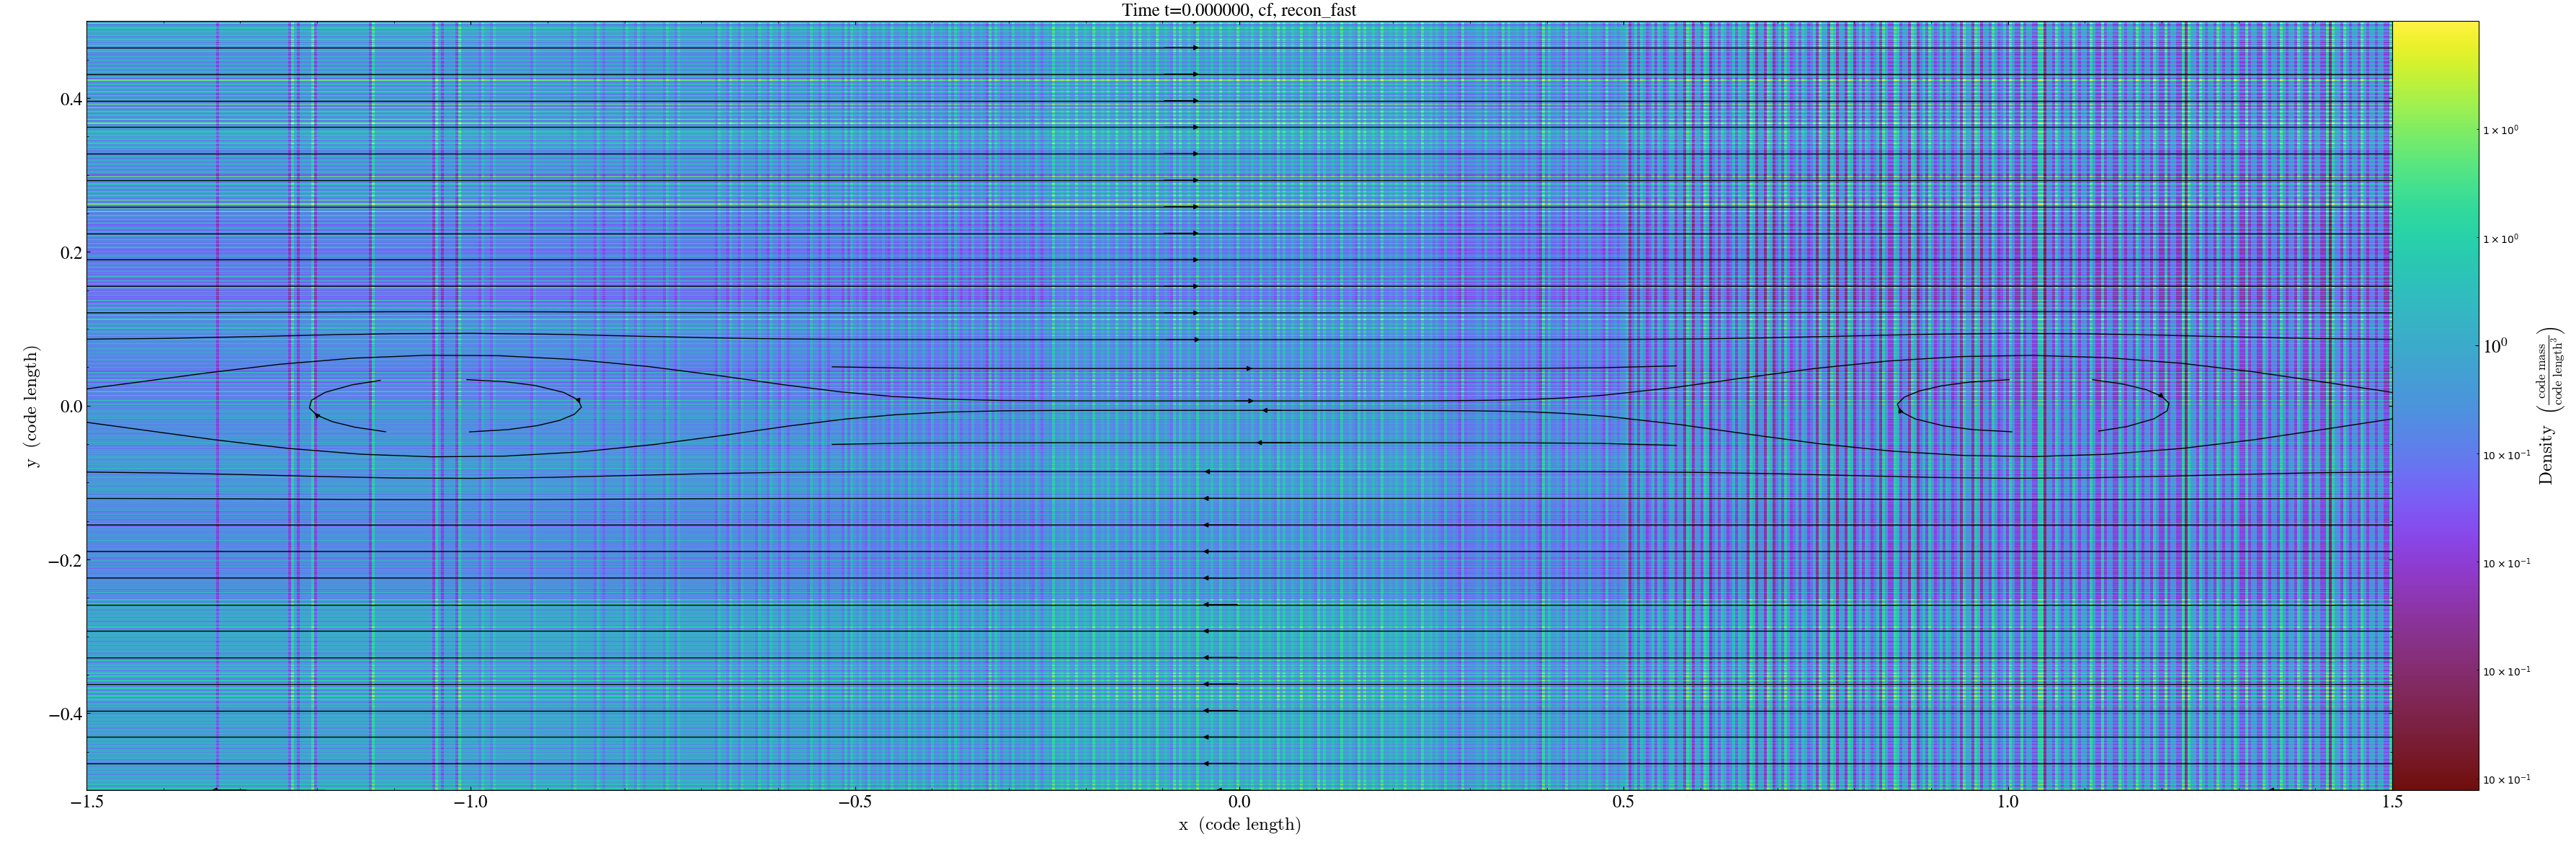

In [4]:
## Plotting a single dataset
index = 0
dictkey, basename = "cf", "recon_fast"
inputname = "athinput." + basename
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)# , outputnum="out3")
ts = yt.DatasetSeries(fileseries)
time = get_simulation_time(fileseries[index])
ds = ts[index]
# print(fileseries)

field = density
p = yt.SlicePlot(ds, "z", field) #, window_size=(8,6))

# p.zoom(20)
p.set_figure_size(32)
# p.pan((-0.02,0))
# xmin, xmax, ymin, ymax = -0.00625, 0.00625, -0.027778, 0.027778


# p.annotate_velocity()
p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"), color='black')

if field==current_eta_z: p.set_log(field, False)
# p.set_log(field, False)
# p.annotate_grids()

p.annotate_title(f'Time t={time:.6f}, {dictkey}, {basename}')
# xrange, yrange = 1, 0.05
# fig = p.export_to_mpl_figure((1,1))
# fig.set_size_inches(20,12)
# fig.axes[0].set_ylim(-yrange,yrange)
# fig.axes[0].set_xlim(-xrange,xrange)
# fig.axes[0].set_box_aspect(0.33333)
# fig.savefig(f"figures/{dictkey}_t{time:.3f}_plasmoid.png", bbox_inches="tight", dpi=300)
# p.save(f"figures/{dictkey}_t{time:.3f}_z10_plasmoid.png", mpl_kwargs={"bbox_inches":"tight", "dpi":300})
p

In [3]:
## Plotting multiple different fields
# Choose the dataset index
index = 0
dictkey = "st1"
basename = "recon_GEM"
inputname = "athinput." + basename       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)
print(fileseries[index])
ts = yt.DatasetSeries(fileseries)
ds = ts[index]
# p = yt.plot_2d(ds, ("athena_pp","press"))
# p.annotate_grids()
# p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

fields = [
('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'),
('gas', 'mach_number'), ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'),
('gas', 'density'), ('gas', 'pressure'), ('gas', 'plasma_beta'), 
]
p = yt.SlicePlot(ds, "z", fields)
fig = p.export_to_mpl_figure((3, 3))
fig.suptitle("Timestep " + str(index))

# Adjust the layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to prevent overlap with suptitle
fig.set_size_inches(12,12)
fig.subplots_adjust(wspace=0.05, hspace=0.01)  # Set small values for minimal spacing

# Iterate over each axis in the figure to modify the colorbar labels
for ax, field in zip(fig.axes, fields):
    if hasattr(ax, 'images') and ax.images:
        img = ax.images[0]
        cbar = img.colorbar
        if cbar is not None:
            # Set the font size for the colorbar labels
            cbar.ax.tick_params(labelsize=8)
            # Set the custom label for the colorbar
            cbar.set_label(field[1], fontsize=14)
            


KeyError: 'st1'

In [ ]:
## Getting radial profiles
index = 1
dictkey = "magnoh_m18"
basename = 'magnoh_smooth'       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)
ts = yt.DatasetSeries(fileseries)
ds = ts[index]

field = pressure

my_sphere = ds.sphere("C", 3.0)

plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    field,
)

plot.set_log(("index", "radius"), False)
plot.set_log(field, False)
plot.annotate_title("Pressure of smooth_magnoh v1")
plot.save("figures/cycle1_smooth_v1.png")

plot.show()


# dims = (600, 600)

# all_data = ds.all_data()
# p = np.reshape(all_data[pressure], dims)[300, :]
# d = np.reshape(all_data[density], dims)[300, :]
# ux = np.reshape(all_data[momentum_x], dims)[300, :]

# x = np.linspace(-3.0, 3.0, 600)

# plt.plot(x, p, label="p")
# plt.plot(x, ux, label="ux")
# # plt.plot(x, d, label="d")
# plt.legend()
# plt.show()

In [ ]:
## Plotting a bunch of datasets in a row
for index in trange(100, 200):
    dictkey, basename = "1e-7", "recon_fast"
    inputname = "athinput." + basename
    fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)# , outputnum="out3")
    ts = yt.DatasetSeries(fileseries)
    time = get_simulation_time(fileseries[index])
    ds = ts[index]

    field = density
    p = yt.SlicePlot(ds, "z", field) #, window_size=(8,6))

    p.zoom(10)
    p.set_figure_size(32)
    # p.pan((1,0))
    # xmin, xmax, ymin, ymax = -0.00625, 0.00625, -0.027778, 0.027778
    # draw_xy_box(p, xmin, xmax, ymin, ymax)

    # p.annotate_velocity()
    p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

    if field==current_eta_z: p.set_log(field, False)
    # p.annotate_grids()

    p.annotate_title(f'Time t={time:.6f}, {dictkey}, {basename}')
    fig = p.export_to_mpl_figure((1,1))
    fig.savefig(f"figures/frames/{dictkey}_t{index:05}_plasmoid_density.png", bbox_inches="tight")
    plt.close("all")


100%|██████████| 100/100 [14:46<00:00,  8.86s/it]


In [ ]:
plt.close("all")

/mnt/gs21/scratch/freem386/recon_fast3/recon_fast.out2.06000.athdf
<class 'numpy.ndarray'>


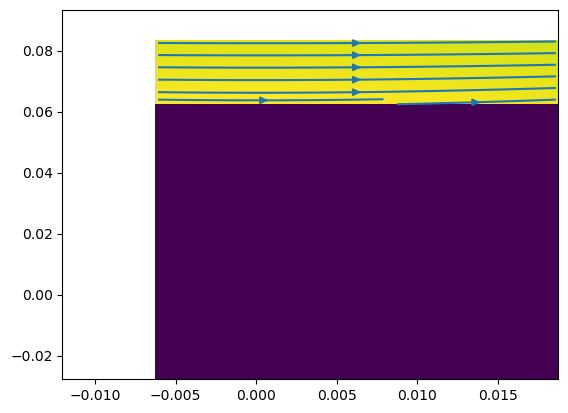

ZeroDivisionError: float division by zero

In [ ]:
## Grabbing raw np data from datasets
write_to_file = True
index = 6000
dictkey = "rs3"
basename = "recon_fast"
inputname = "athinput." + basename       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)
print(fileseries[index])
ts = yt.DatasetSeries(fileseries)
ds = ts[index]
dt = get_simulation_time(fileseries[1]) - get_simulation_time(fileseries[0])

grid_size_const = 6400*2
zoom = 20.0
x_zoom = 8.0
y_zoom = 1.8
xmin = [0-1/zoom/x_zoom, 0-1/zoom/y_zoom, 0]
dims = np.array([grid_size_const//zoom//x_zoom, grid_size_const//zoom//y_zoom,1])

max_level = ds.max_level

# # #
# # To plot these datasets
cg = ds.covering_grid(2, left_edge=xmin, dims=dims)
X, Y = cg["athena_pp","x"], cg["athena_pp","y"]
x = X[:,0,0]
y = Y[0,:,0]
d = cg["gas", "pressure"][:,:,0]
print(type(d.v))
plt.streamplot(x.v, y.v, cg["gas", "magnetic_field_x"][:,:,0].v.T, cg["gas", "magnetic_field_y"][:,:,0].v.T)
plt.pcolor(x, y, d.T)
plt.show()
x = 1.0/0.0
# # #

# print(xmin)
max_level = ds.max_level

h = f"# Total zoom {zoom}, total x-zoom {x_zoom}, total y-zoom {y_zoom}\n"
h = h + f"# i \t|\t\t t \t|\t MEtot\t|\t dMEtot \t|\t KEtot\t|\t dKEtot \t|\t Pdvtot \t|\t dTEtot \t|\t Etot"
print(h)
if write_to_file == True:
    fname = f"energies_{zoom:.2f}x_with_flux_{dictkey}.txt"
    f = open(fname, "a")
    f.write(h + "\n")
    print(f"writing to file " + fname)

for i in range(100, 6000):
    ds = ts[i]
    cg = ds.covering_grid(max_level, left_edge=xmin, dims=dims)
    tnow = get_simulation_time(fileseries[i])
    tprev = get_simulation_time(fileseries[i-1])
    dt = tnow - tprev
    # print(dt)

    X, Y = cg["athena_pp","x"].v, cg["athena_pp","y"].v
    x = X[:,0,0]
    y = Y[0,:,0]

    d = cg["gas", "density"][:,:,0].v
    u = cg["gas", "velocity_x"][:,:,0].v
    v = cg["gas", "velocity_y"][:,:,0].v
    w = cg["gas", "velocity_z"][:,:,0].v
    vel = cg["gas", "velocity_magnitude"][:,:,0].v
    ked = 0.5*np.multiply(d, vel*vel)

    dx = cg["athena_pp", "dx"][0,0,0].v
    dy = cg["athena_pp", "dy"][0,0,0].v
    dz = cg["athena_pp", "dz"][0,0,0].v
    dv = dx*dy*dz

    med = cg["gas", "magnetic_energy_density"][:,:,0].v

    p = cg["gas", "pressure"][:,:,0].v
    # gamma = 1.001       # p=(g-1)d*e
    # e = p/(gamma-1)/d
    
    # Slicing to *JUST* inside the original frame so we don't double count edges
    TEtot = np.sum(p[1:-1])*dv
    MEtot = np.sum(med[1:-1])*dv
    KEtot = np.sum(ked[1:-1])*dv
    Etot = TEtot + MEtot + KEtot
    
    mechange = change_in_box(med, u, v, dx, dy, dz, dt)
    kechange = change_in_box(ked, u, v, dx, dy, dz, dt)
    techange = change_in_box(p, u, v, dx, dy, dz, dt)

    s = f"{i}\t,\t{tnow:.5e},\t{MEtot:.5e},\t{mechange:.5e}\t,\t{KEtot:.5e}\t,\t{kechange:.5e}\t,\t{TEtot:.5e}\t,\t{techange:.5e}\t,\t{Etot:.5e}"
    print(s)
    if write_to_file == True: f.write(s + "\n")
    

if write_to_file == True: f.close()

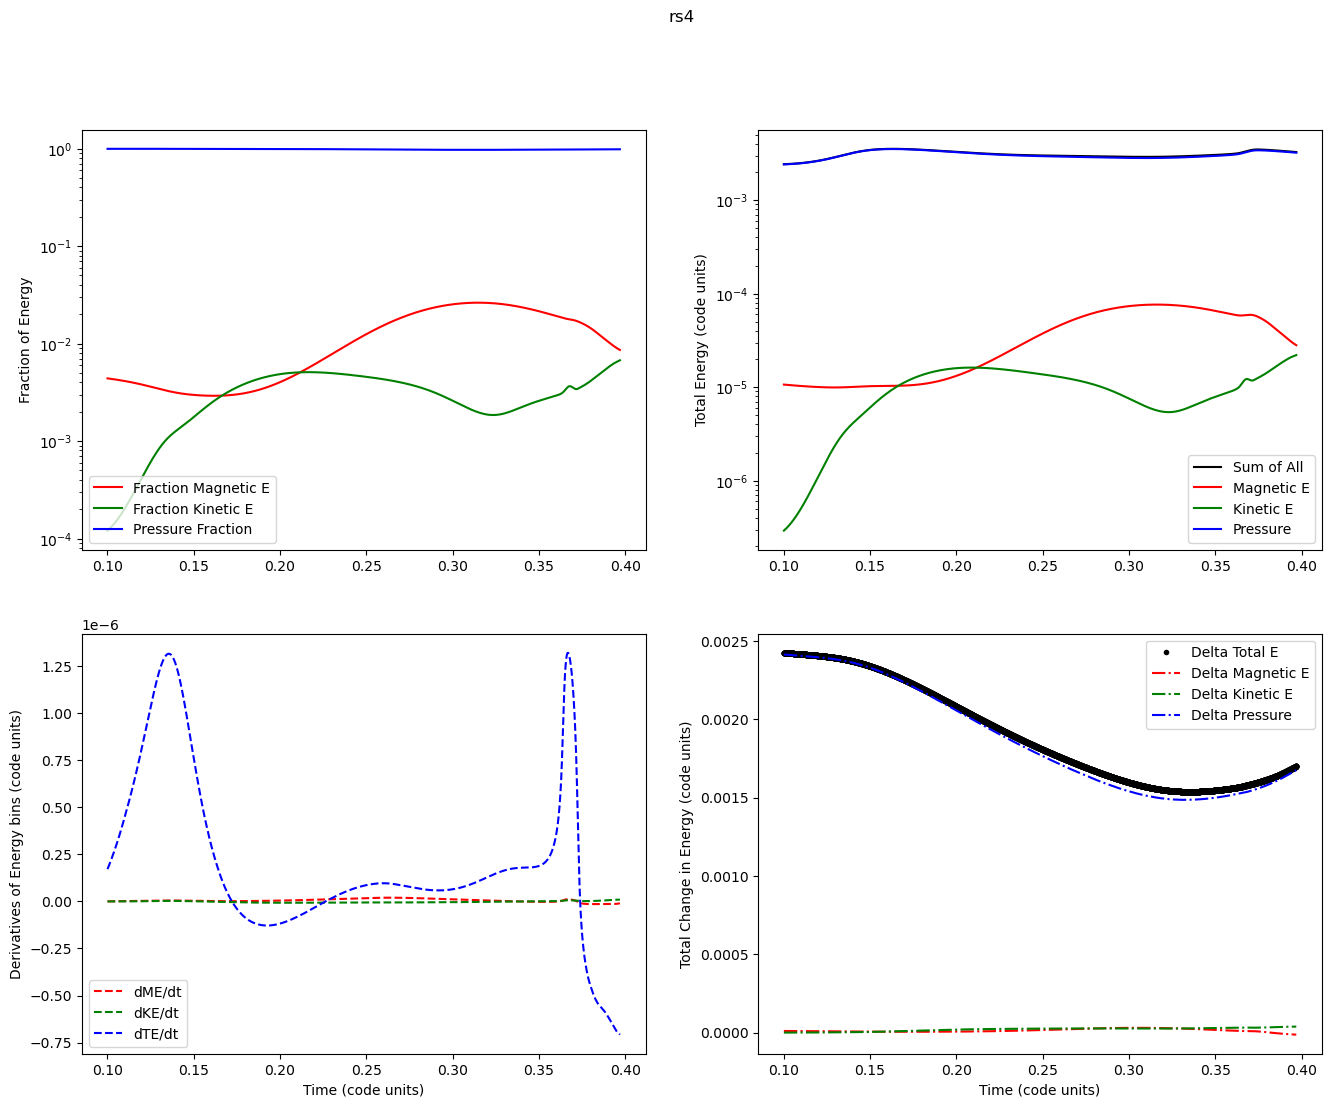

In [ ]:
alldata = np.loadtxt("energies_20.00x_with_flux_rs4_s101_e7900.txt", delimiter=",")
dictkey = "rs4"
# alldata = np.loadtxt("energies_20.00x_with_flux_rs1.txt", delimiter=",")
# dictkey = "rs1"

# dt = 0.0005
ii, ti, mei, kei, pi, eti = 0, 1, 2, 4, 6, 8
mefi, kefi, tefi = 3, 5, 7
t, me, ke, p, et = alldata[:,ti], alldata[:,mei], alldata[:,kei], alldata[:,pi], alldata[:,eti]
mef, kef, tef = alldata[:,mefi], alldata[:, kefi], alldata[:, tefi]
deltaME, deltaKE, deltaTE, deltaE = np.zeros_like(me), np.zeros_like(ke), np.zeros_like(p), np.zeros_like(et)

# # Generating a dt array
# dt = np.zeros_like(t)
# for j in range(len(dt)-1):
#     dt[j+1] = t[j+1]-t[j]
# dt[0] = dt[-1] # Filling out last with just equivalent of previous

grid_size_const = 6400*2
zoom = 20.0
x_zoom = 8.0
y_zoom = 1.8
xmin = [0-1/zoom/x_zoom, 0-1/zoom/y_zoom, 0]

roi = 1        # Region of interest (integer) - integer to START plots from
# roi = 1

f, ax = plt.subplots(2,2)
f.set_size_inches(16, 12)
ax[0,0].plot(t[roi:], me[roi:]/et[roi:], "r-", label="Fraction Magnetic E")
ax[0,0].plot(t[roi:], ke[roi:]/et[roi:], "g-", label="Fraction Kinetic E")
ax[0,0].plot(t[roi:], p[roi:]/et[roi:], "b-", label="Pressure Fraction")

ax[1,0].plot(t[roi:], mef[roi:], "r--", label="dME/dt")
ax[1,0].plot(t[roi:], kef[roi:], "g--", label="dKE/dt")
ax[1,0].plot(t[roi:], tef[roi:], "b--", label="dTE/dt")

ax[0,1].plot(t[roi:], et[roi:], "k", label="Sum of All")
ax[0,1].plot(t[roi:], me[roi:], "r-", label="Magnetic E")
ax[0,1].plot(t[roi:], ke[roi:], "g-", label="Kinetic E")
ax[0,1].plot(t[roi:], p[roi:], "b-", label="Pressure")

# Calculating total minus change at each timestep
total_change_me, total_change_ke, total_change_te = 0, 0, 0
for j in range(len(t)):
    total_change_me += mef[j]
    total_change_ke += kef[j]
    total_change_te += tef[j]
    
    deltaME[j] = me[j] - total_change_me
    deltaKE[j] = ke[j] - total_change_ke
    deltaTE[j] = p[j] - total_change_te
    deltaE[j] = deltaME[j] + deltaKE[j] + deltaTE[j]
    et[j] = et[j] - total_change_me - total_change_ke - total_change_te
    # if 16700 < j < 16800: print(j, total_change_me, deltaME[j])
# 1.0/0.0

ax[1,1].plot(t[roi:], deltaE[roi:], "k.", label="Delta Total E")
ax[1,1].plot(t[roi:], deltaME[roi:], "r-.", label="Delta Magnetic E")
ax[1,1].plot(t[roi:], deltaKE[roi:], "g-.", label="Delta Kinetic E")
ax[1,1].plot(t[roi:], deltaTE[roi:], "b-.", label="Delta Pressure")

ax[0,0].legend(loc=3)
ax[0,0].set_ylabel("Fraction of Energy")
ax[0,0].set_yscale("log")
ax[1,0].legend()
ax[1,0].set_ylabel("Derivatives of Energy bins (code units)")
ax[1,0].set_xlabel("Time (code units)")
ax[0,1].legend()
ax[0,1].set_ylabel("Total Energy (code units)")
ax[0,1].set_yscale("log")
ax[1,1].legend()
ax[1,1].set_ylabel("Total Change in Energy (code units)")
ax[1,1].set_xlabel("Time (code units)")


# ax.set_yscale("log")
f.suptitle(dictkey)
f.show()
plt.savefig(f"energy_quantities_{dictkey}_z{zoom}_xmin{xmin[0]:.3e}_ymin{xmin[1]:.3e}.png")

In [ ]:
## Todo check to see where the energy is being stored - thermal energy should spike and magnetic energy should dip if reconnection happens interestingly
ts = yt.DatasetSeries(fileseries)
ke_tot = np.zeros(max_index//step + 1)
me_tot = np.zeros(max_index//step + 1)
te_tot = np.zeros(max_index//step + 1)

for index in range(max_index//step + 1):
    print("{:.3f}".format(100*index*step/max_index), end='\r')
    # Calculating grid information for NP sums
    ds = ts[index]
    max_level = ds.index.max_level      # Max AMR level - included for if AMR is turned on later
    low = ds.domain_left_edge           # Domain left edge for numpy conversion starting region
    dims = ds.domain_dimensions         # Dimensions of full domain

    all_data_level_0 = ds.covering_grid(level=max_level, left_edge=low, dims=dims)
    ke_tot[index] = np.sum(all_data_level_0["gas", "kinetic_energy_density"])
    me_tot[index] = np.sum(all_data_level_0["gas", "magnetic_energy_density"])
    te_tot[index] = np.sum(all_data_level_0["gas", "pressure"])

NameError: name 'max_index' is not defined

In [ ]:
## Dump energy totals... Deprecated
import pickle as pkl
pkl.dump(ke_tot, open(f"ke_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))
pkl.dump(me_tot, open(f"me_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))
pkl.dump(te_tot, open(f"te_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))

In [ ]:
## Retrieve energy totals... Deprecated
import pickle as pkl
ke_tot = pkl.load(open(f"ke_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))
me_tot = pkl.load(open(f"me_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))
te_tot = pkl.load(open(f"te_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))

0.003166286988823053 code_pressure


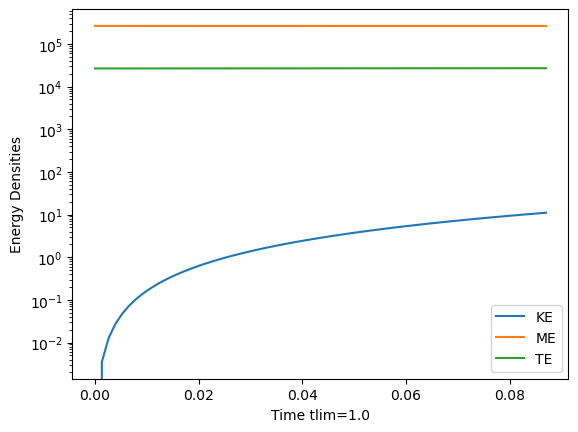

[0.00000000e+00 3.51154595e-03 1.28171343e-02 2.75969494e-02
 4.77478836e-02 7.32051454e-02 1.03921950e-01 1.39861821e-01
 1.80994838e-01 2.27295561e-01 2.78741780e-01 3.35313703e-01
 3.96993405e-01 4.63764440e-01 5.35611560e-01 6.12520500e-01
 6.94477819e-01 7.81470769e-01 8.73487202e-01 9.70515479e-01
 1.07254442e+00 1.17956321e+00 1.29156143e+00 1.40852893e+00
 1.53045586e+00 1.65733260e+00 1.78914978e+00 1.92589821e+00
 2.06756891e+00 2.21415306e+00 2.36564197e+00 2.52202715e+00
 2.68330019e+00 2.84945282e+00 3.02047690e+00 3.19636438e+00
 3.37710730e+00 3.56269781e+00 3.75312814e+00 3.94839058e+00
 4.14847753e+00 4.35338145e+00 4.56309484e+00 4.77761029e+00
 4.99692044e+00 5.22101799e+00 5.44989568e+00 5.68354632e+00
 5.92196274e+00 6.16513785e+00 6.41306457e+00 6.66573587e+00
 6.92314476e+00 7.18528429e+00 7.45214753e+00 7.72372761e+00
 8.00001766e+00 8.28101086e+00 8.56670041e+00 8.85707955e+00
 9.15214162e+00 9.45187995e+00 9.75628787e+00 1.00653587e+01
 1.03790858e+01 1.069746

In [ ]:
## Plotting energy over time
index = 0
ds = ts[index]
max_level = ds.index.max_level      # Max AMR level - included for if AMR is turned on later
low = ds.domain_left_edge           # Domain left edge for numpy conversion starting region
dims = ds.domain_dimensions         # Dimensions of full domain

all_data_level_0 = ds.covering_grid(level=max_level, left_edge=low, dims=dims)
print(all_data_level_0["gas", "pressure"].min())

t = np.arange(0, max_index, step) * 8.78906e-05
plt.plot(t, ke_tot, label='KE')
plt.plot(t, me_tot, label="ME")
plt.plot(t, te_tot, label="TE")
plt.yscale("log")
plt.legend()
plt.ylabel("Energy Densities")
plt.xlabel("Time tlim=1.0")

plt.show()
print(ke_tot)

In [31]:
## Adding missing kinetic/magnetic/pressure ratios and current that are missing in YT 
def _curlBz(field, data):
    return (
        data["gas", "magnetic_field_y_gradient_x"] - data["gas", "magnetic_field_x_gradient_y"]
    )

def _KEoverME(field, data):
    return (
        data["gas", "kinetic_energy_density"] / data["gas", "magnetic_energy_density"]
    )
    
def _KEoverTE(field, data):
    return (
        data["gas", "kinetic_energy_density"] / data["gas", "pressure"]
    )
    
def _ByoverBx(field, data):
    return (
        np.abs(data["gas", "magnetic_field_y"] / data["gas", "magnetic_field_x"])
    )

yt.add_field(
    name=("gas", "curlBz"),
    function=_curlBz,
    sampling_type="local",
    units="code_magnetic/code_length",
    force_override=True,
)
    
yt.add_field(
    name=("gas", "ByoverBx"),
    function=_ByoverBx,
    sampling_type="local",
    units="code_magnetic/code_magnetic",
    force_override=True,
)    
yt.add_field(
    name=("gas", "KEoverME"),
    function=_KEoverME,
    sampling_type="local",
    units="code_pressure/code_pressure",
    force_override=True,
)

yt.add_field(
    name=("gas", "KEoverTE"),
    function=_KEoverTE,
    sampling_type="local",
    units="code_pressure/code_pressure",
    force_override=True,
)

def _current_eta_z(field, data):
    Jz = data["gas", "velocity_x"]*data["gas", "magnetic_field_y"] - data["gas", "velocity_y"]*data["gas", "magnetic_field_x"]
    return Jz
yt.add_field(
    name=("gas", "current_eta_z"),
    function=_current_eta_z,
    sampling_type="local",
    units="code_magnetic*code_velocity",
    force_override=True,
)

In [ ]:
ds.derived_field_list

[('athena_pp', 'Bcc1'),
 ('athena_pp', 'Bcc2'),
 ('athena_pp', 'Bcc3'),
 ('athena_pp', 'cell_volume'),
 ('athena_pp', 'dx'),
 ('athena_pp', 'dy'),
 ('athena_pp', 'dz'),
 ('athena_pp', 'path_element_x'),
 ('athena_pp', 'path_element_y'),
 ('athena_pp', 'path_element_z'),
 ('athena_pp', 'press'),
 ('athena_pp', 'rho'),
 ('athena_pp', 'vel1'),
 ('athena_pp', 'vel2'),
 ('athena_pp', 'vel3'),
 ('athena_pp', 'volume'),
 ('athena_pp', 'x'),
 ('athena_pp', 'y'),
 ('athena_pp', 'z'),
 ('gas', 'alfven_speed'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'baroclinic_vorticity_magnitude'),
 ('gas', 'baroclinic_vorticity_x'),
 ('gas', 'baroclinic_vorticity_y'),
 ('gas', 'baroclinic_vorticity_z'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'courant_time_step'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('g

In [ ]:
params = parse_input_file('/mnt/gs21/scratch/freem386/reduction2/athinput.recon_gauss_harris', ['eta_ohm', 'P0'])
print(params)
eta_ohm = parse_input_file('/mnt/gs21/scratch/freem386/reduction2/athinput.recon_gauss_harris', ['eta_ohm', 'P0'])['eta_ohm']
print(eta_ohm)

S_L = v_a * L / eta_ohm
print(f"{S_L:.4e}")

{'eta_ohm': 1e-07, 'P0': 1.0}
1e-07
5.0000e+05


In [ ]:
## BAD BAD BAD way to calculate MFT flux
print(ds)

def _current_eta_z(field, data):
    Jz = data["gas", "velocity_x"]*data["gas", "magnetic_field_y"] - data["gas", "velocity_y"]*data["gas", "magnetic_field_x"]
    return Jz
ds.add_field(
    name=("gas", "current_eta_z"),
    function=_current_eta_z,
    sampling_type="local",
    units="code_magnetic*code_velocity",
    force_override=True,
)
def _B_squared(data):
    """|B|² with units, w/ tiny floor to avoid divide-by-zero."""
    Bx = data["gas", "magnetic_field_x"]
    By = data["gas", "magnetic_field_y"]
    Bz = data["gas", "magnetic_field_z"]
    B2 = Bx**2 + By**2 + Bz**2
    floor = 1e-50                 # floor included so we don't erroneously divide by 0
    return B2 + floor*Bx.units**2
def _mft_x(field, data):
    eta = data["gas", "current_eta_z"]
    By  = data["gas", "magnetic_field_y"]
    mft_x = (-eta * By) / _B_squared(data)
    return  mft_x     #  -η  B_y / |B|²
def _mft_y(field, data):
    eta = data["gas", "current_eta_z"]
    Bx  = data["gas", "magnetic_field_x"]
    mft_y = (eta * Bx) / _B_squared(data)
    return mft_y       #   η  B_x / |B|²
for comp, func in zip(
        ["magnetic_flux_transport_x",
        "magnetic_flux_transport_y"],
        [_mft_x, _mft_y]):

    ds.add_field(
        ("gas", comp),
        function=func,
        units="code_velocity",                 # supply the correct units!
        sampling_type="local",
        force_override=True,
    )
    
def _mft_divergence(field, data):
    Fx = data["gas", "magnetic_flux_transport_x"]
    Fy = data["gas", "magnetic_flux_transport_y"]
    print(Fx.shape)

    dx = data["index", "dx"]
    dy = data["index", "dy"]

    # pre-allocate result, keep units:  (code_velocity / code_length)
    div = data.ds.arr(np.empty_like(Fx.value), Fx.units / dx.units)

    # ---------- ∂F_x/∂x ----------
    # interior cells (central)
    den_x = 0.5 * (dx[2:] + dx[:-2])
    div[1:-1, :, :]  = (Fx[2:, :, :] - Fx[:-2, :, :]) / den_x

    # lower x-edge (forward)
    den_lo = 0.5 * (dx[1] + dx[0])
    div[0, :, :]     = (Fx[1, :, :] - Fx[0, :, :]) / den_lo

    # upper x-edge (backward)
    den_hi = 0.5 * (dx[-1] + dx[-2])
    div[-1, :, :]    = (Fx[-1, :, :] - Fx[-2, :, :]) / den_hi

    # ---------- ∂F_y/∂y ----------
    # interior (central)
    den_y = 0.5 * (dy[:, 2:] + dy[:, :-2])
    div[:, 1:-1, :] += (Fy[:, 2:, :] - Fy[:, :-2, :]) / den_y

    # lower y-edge (forward)
    den_lo = 0.5 * (dy[:, 1] + dy[:, 0])
    div[:, 0, :]    += (Fy[:, 1, :] - Fy[:, 0, :]) / den_lo

    # upper y-edge (backward)
    den_hi = 0.5 * (dy[:, -1] + dy[:, -2])
    div[:, -1, :]   += (Fy[:, -1, :] - Fy[:, -2, :]) / den_hi

    return div
ds.add_field(
    ("gas", "magnetic_flux_transport_divergence"),
    function        = _mft_divergence,
    sampling_type   = "cell",
    units           = "code_velocity/code_length",
    force_override  = True,
)
cg = ds.covering_grid(level      = 0,
                      left_edge  = ds.domain_left_edge,
                      dims       = ds.domain_dimensions,
                      num_ghost_zones = 0)
field = ("gas", "magnetic_flux_transport_divergence")
slc = yt.SlicePlot(ds, "z", field, data_source=cg) #, window_size=(8,6))
slc.show()

recon_fast.out2.00400
(16, 16, 16)


YTDataSelectorNotImplemented: Data selector 'covering_grid' not implemented.

<bound method Figure.show of <Figure size 2000x1000 with 4 Axes>>

<Figure size 640x480 with 0 Axes>

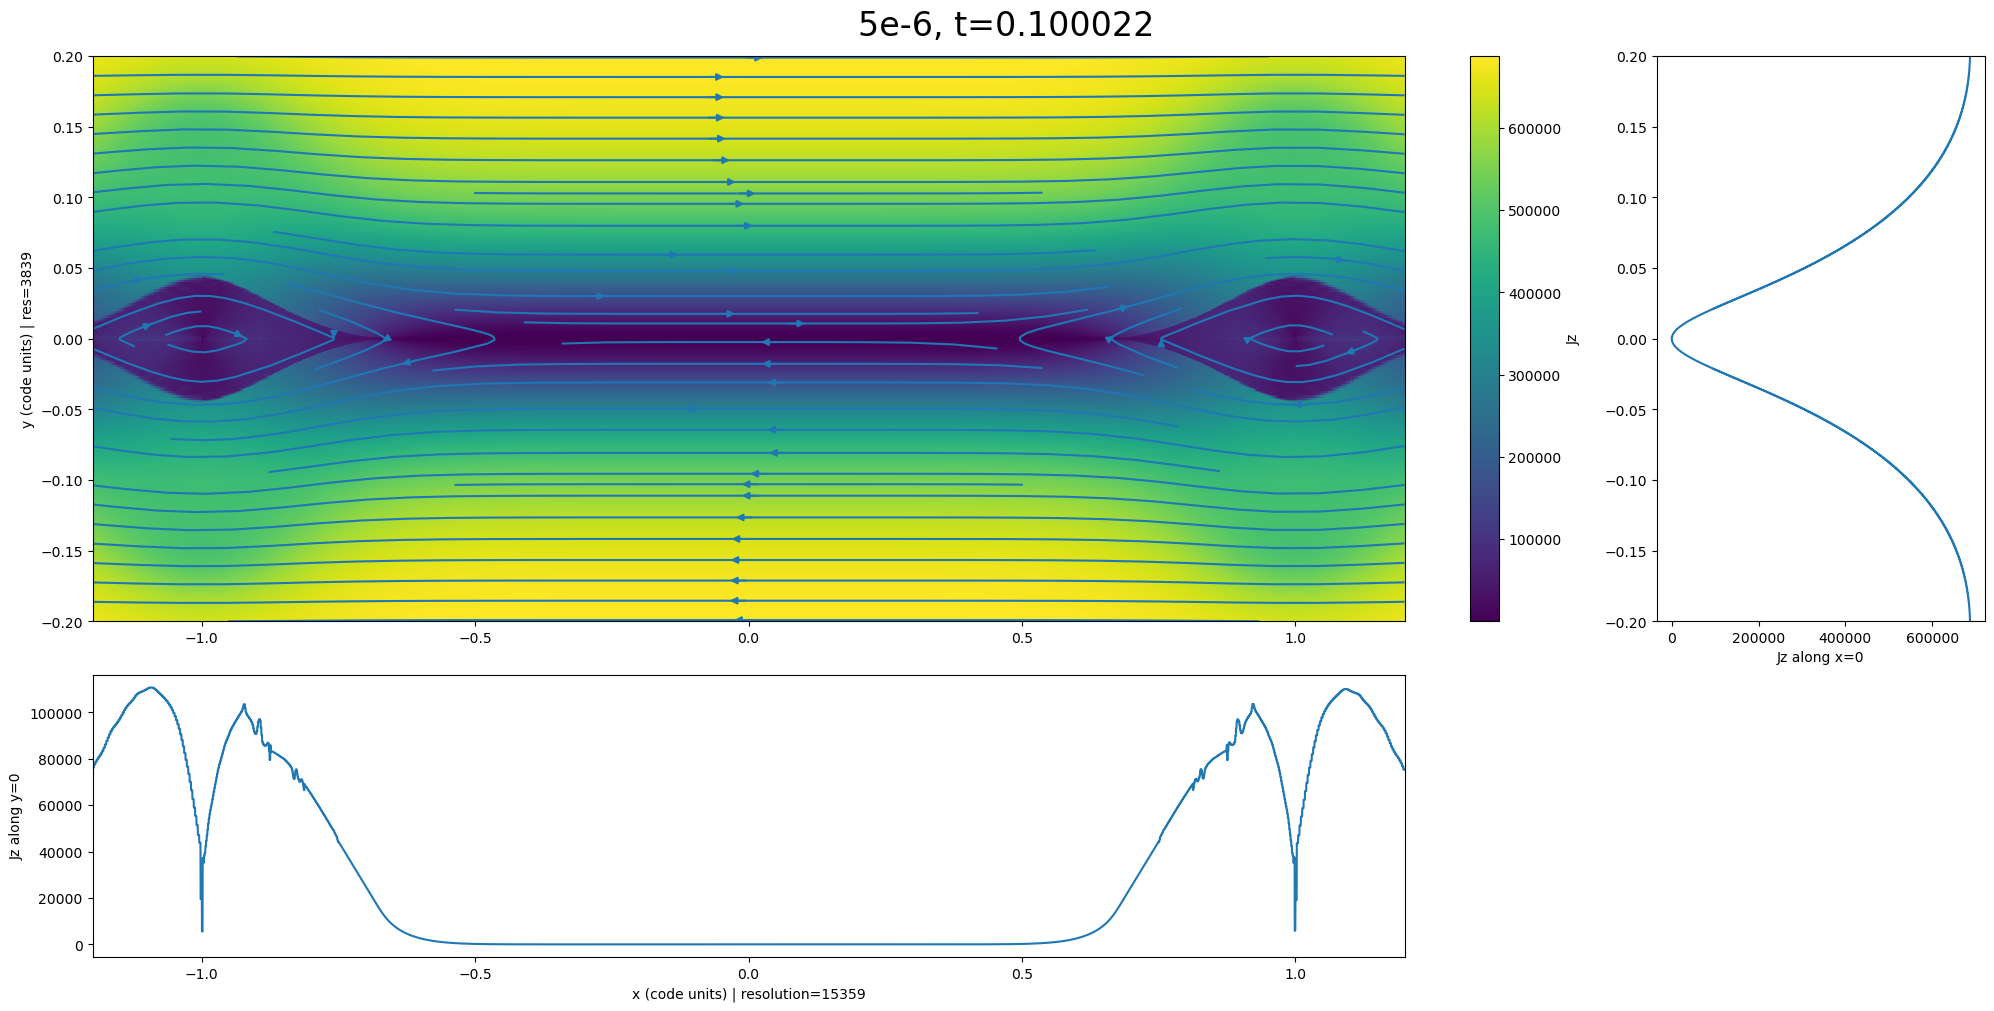

In [ ]:
## Plotting and doing math on raw numpy values
import matplotlib.colors as colors
index = 10
# for index in range(1, 700):
dictkey, basename = "5e-6", "recon_fast"
inputname = "athinput." + basename
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)# , outputnum="out3")
ts = yt.DatasetSeries(fileseries)
time = get_simulation_time(fileseries[index])
ds = ts[index]

xminbox, xmaxbox = -1.2, 1.2
yminbox, ymaxbox = -0.2, 0.2
input_params = parse_input_file(f'/mnt/gs21/scratch/freem386/vary_eta/eta_{dictkey}/athinput.recon_gauss_harris')

# A bunch of math to determine the size of the covering grid arrays
level = input_params["refinement1_level"]
Nx = input_params["mesh_nx1"] * 2**(level)
Ny = input_params["mesh_nx2"] * 2**(level)

xmin, xmax = input_params["mesh_x1min"], input_params["mesh_x1max"]
ymin, ymax = input_params["mesh_x2min"], input_params["mesh_x2max"]

dx, dy = (xmax - xmin)/Nx, (ymax - ymin)/Ny
i0, j0 = (xminbox - xmin)//dx, (yminbox - ymin)//dy
iN, jN = (xmaxbox - xminbox)//dx, (ymaxbox - yminbox)//dy
i0, j0, iN, jN = int(np.floor(i0)), int(np.floor(j0)), int(np.ceil(iN)), int(np.ceil(jN))

# Actually defining the grid
cg = ds.covering_grid(level=level, left_edge=[xminbox, yminbox, 0], dims=[iN, jN, 1])
X, Y = np.reshape(cg["athena_pp","x"].v, (iN, jN)), np.reshape(cg["athena_pp","y"].v, (iN, jN))
x = X[:,0]
y = Y[0,:]
vx = cg["gas", "velocity_x"][:,:,0].v
vy = cg["gas", "velocity_y"][:,:,0].v
Bx = cg["gas", "magnetic_field_x"][:,:,0].v
By = cg["gas", "magnetic_field_y"][:,:,0].v
rho = cg["gas", "density"][:,:,0].v
# P = cg["gas", "pressure"][:,:,0].v
va = cg["gas", "alfven_speed"][:,:,0].v
Ma = cg["gas", "mach_alfven"][:,:,0].v

eta_ohm = input_params["problem_eta_ohm"]
Ez = vx*By - vy*Bx
Jz = Ez/eta_ohm
# B = cg["gas", "magnetic_field_strength"][:,:,0].v
# bx, by = Bx/B, By/B

# MFTx = Ez/B * -by
# MFTy = Ez/B * bx

# thing = dFdy(Bx,dy)  # div2D(MFTx, MFTy, dx, dy)
# thing = B**2/P
# thing = np.abs(vx)/va
# thing = np.abs(By/Bx)
# thing = rho; thinglabel="density"
thing = Jz; thinglabel="Jz"
thing1d = thing

plt.clf()
gs_kw = dict(width_ratios=[1.0, 0.25], height_ratios=[1, 0.5])
fig, ax = plt.subplots(2, 2, gridspec_kw=gs_kw, layout='constrained')
# Colormesh, colorbar, streamplot
p1 = ax[0,0].pcolormesh(X, Y, thing)#, norm=colors.LogNorm())
cbar = plt.colorbar(p1)
ax[0,0].streamplot(x, y, Bx.T, By.T)
cbar.ax.set_ylabel(f"{thinglabel}", rotation=90)
ax[0,0].set_ylabel(f"y (code units) | res={Y.shape[1]}")
ax[0,0].set_xlim(xminbox, xmaxbox)
ax[0,0].set_ylim(yminbox, ymaxbox)
# y=0 slice
ax[1,0].plot(X[:,jN//2], thing1d[:,jN//2])
ax[1,0].set_ylabel(f"{thinglabel} along y=0")
ax[1,0].set_xlabel(f"x (code units) | resolution={X.shape[0]}")
ax[1,0].set_xlim(xminbox,xmaxbox)
# x=0 slice
ax[0,1].plot(thing1d[iN//2,:], Y[iN//2,:])
ax[0,1].set_xlabel(f"{thinglabel} along x=0")
ax[0,1].set_ylim(yminbox, ymaxbox)
# Delete unused axis
fig.delaxes(ax[1,1])

fig.suptitle(f"{dictkey}, t={get_simulation_time(fileseries[index]):.6f}", fontsize=24)
fig.set_size_inches(20, 10)
# fig.show()

# print(X.shape)
# print(index, end="\r")
# fig.savefig(f"figures/test/mach_alfven_{dictkey}_{index:05}")
# plt.close("all")
fig.show

In [ ]:
fig.savefig("figures/Current_5e-6_early.png")

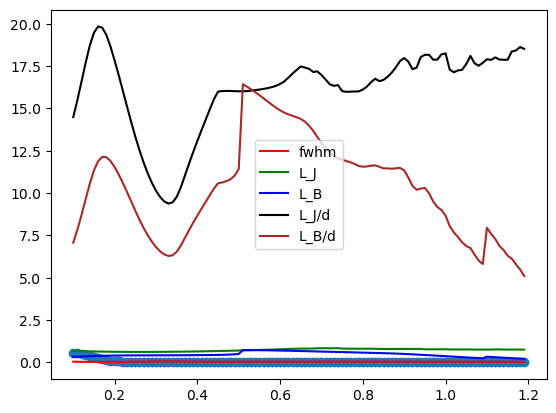

In [ ]:
aspect = np.loadtxt("ff1e-5_sheeet_features.txt", delimiter=",", skiprows=1)
times = aspect[:,0]
fwhm = aspect[:,1]
L_J = aspect[:,2]
L_B = aspect[:,3]
Lod_J = aspect[:,4]
Lod_B = aspect[:,5]
v_A = aspect[:,6]
expir_rate = aspect[:,7]
plt.plot(times, fwhm, color="red", label="fwhm")
plt.plot(times, L_J, color="green", label="L_J")
plt.plot(times, L_B, color="blue", label="L_B")
plt.plot(times, Lod_J, color="black", label="L_J/d")
plt.plot(times, Lod_B, color="brown", label="L_B/d")
plt.scatter(times, expir_rate)
plt.legend()

In [9]:
plt.scatter(L_J*v_A/1e-5, expir_rate)
plt.scatter(L_J*v_A/1e-5, (L_J*v_A/1e-5)**(-1/2))

NameError: name 'L_J' is not defined